In [1]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import os
from tqdm import tqdm

In [25]:
torch.__version__

'2.2.1+cu121'

In [2]:
%pip install rotary-embedding-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.7/903.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyli

In [4]:
from rotary_embedding_torch import RotaryEmbedding
from mamba import MambaConfig, MambaBlock

In [5]:
class InductionAR(Dataset):
    # In induction head we have ngram = 1. But the code provided is for general ngram setting. While using this, initialize ngram = 1.
    """ Naive associative recall dataset """
    # num_examples is dataset size
    # n_gram is length of the query, M
    # n_ctx is length of the seq, L
    # daley is distance between query and target value, tau
    def __init__(self, num_examples, tokenizer, n_gram=1, n_ctx = 1024, seed = 0, train_split=0.8, delay = 1):
        self.num_examples = num_examples
        self.tokenizer = tokenizer
        self.n_ctx = n_ctx
        self.seed = seed
        self.n_gram = n_gram
        self.delay = delay
        x, y = self.data_gen()
        if train_split:
            self.train_x, self.train_y, self.test_x, self.test_y = self.split(x, y, train_split)
            self.train = self.numpy_to_tensor_dataset(self.train_x, self.train_y)
            self.test = self.numpy_to_tensor_dataset(self.test_x, self.test_y)
        else:
            self.train_x, self.train_y, self.test_x, self.test_y = x, y, None, None
            self.train = self.numpy_to_tensor_dataset(self.train_x, self.train_y)
            self.test = None
    '''
    Gives the dataset from list of numbers into string
    '''
    def get_str_dataset(self, split="train"):
        if split == "train":
            x_str = [self.tokenizer.decode(xi) for xi in self.train_x]
            y_str = [self.tokenizer.decode([yi]) for yi in self.train_y]
        elif split == "test":
            x_str = [self.tokenizer.decode(xi) for xi in self.test_x]
            y_str = [self.tokenizer.decode([yi]) for yi in self.test_y]
        else:
            raise ValueError("split should be either 'train' or 'test'")
        return x_str, y_str
    def numpy_to_tensor_dataset(self, x, y):
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return TensorDataset(x, y)
    def gen_single_example(self):
        # get the vocab size
        def count(str_x, str_n_gram_head):
            counts = sum([
                str_x.startswith(str_n_gram_head, i) for i in range(len(str_x))
            ])
            return counts
        def gen_x():
            gen_x_success = False
            while not gen_x_success:
                x = np.random.choice(vocab, self.n_ctx-self.n_gram*2, replace=True).tolist()
                # remove the case where the n_gram_head is repeated in the sequence
                for _ in range(10):
                    pos = [i for i in range(len(x)-len(n_gram_head)+1) if x[i:i+len(n_gram_head)] == n_gram_head]
                    if len(pos) == 0:
                        gen_x_success = True
                        break
                    else:
                        # remove the n_gram_head from x
                        # get all positions of the n_gram_head in x
                        for p in reversed(pos):
                            # remove len(n_gram_head) elements from x starting from p
                            x = x[:p] + x[p+len(n_gram_head):]
                        # fill the rest of the sequence with random elements
                        x.extend(np.random.choice(vocab, self.n_ctx-self.n_gram*2-len(x), replace=True).tolist())
                x_test = " ".join([str(xi) for xi in x])
                if count(x_test, str_n_gram_head) == 0:
                    gen_x_success = True

            x_test = x + n_gram_head
            # check if there's only one n_gram_head in the sequence
            # to avoid the case where the n_gram_head has
            # repeated structure such as x= [1, 2, 3, 1] , n_gram_head = [1, 1]
            str_x_test = " "+" ".join([str(xi) for xi in x_test])+ " "
            if count(str_x_test, str_n_gram_head) > 1:
                print("Error in gen_x")
                print(f"str_x_test: {str_x_test}", f"str_n_gram_head: {str_n_gram_head}",
                      "count: ", count(str_x_test, str_n_gram_head))
            if count(str_x_test, str_n_gram_head) == 1:
                return x
            else:
                return None
        def insert_n_gram_head(x):
            pos = random.randint(0, len(x)-self.delay)
            y = x[pos + self.delay - 1]
            x_new = x[:pos] + n_gram_head + x[pos:] + n_gram_head
            str_x_new = " "+" ".join([str(xi) for xi in x_new])+" "

            if count(str_x_new, str_n_gram_head) == 2:
                return x_new, y
            else:
                return None, None
        vocab_size = len(self.tokenizer)
        vocab = list(range(vocab_size)) # vocab is like [0, 1, .., K-1]
        # set a deterministic n_gram_head
        n_gram_head = list(range(self.n_gram)) # n_gram_head is M, length of the query, [0, 1, 2, .., M-1]

        str_n_gram_head = " "+" ".join([str(xi) for xi in n_gram_head])+" "
        assert self.n_gram*2 < self.n_ctx, "n_gram*2 should be less than n_ctx"
        success = False
        while not success:
            x = gen_x()
            if x is not None:
                for _ in range(10):
                    x_new, y = insert_n_gram_head(x)
                    if x_new is not None:
                        success = True
                        break
        return x_new, y

    def data_gen(self):
        x = []
        y = []
        # get previous random status and recover after generating the dataset
        random_status = random.getstate()
        random.seed(self.seed)
        for i in range(self.num_examples):
            if i % 10000 == 0:
                print(f"Generating example {i}")
            xi, yi = self.gen_single_example()
            x.append(xi)
            y.append(yi)
        x = np.array(x)
        y = np.array(y)
        random.setstate(random_status)
        return x, y
    def split(self, x, y, train_ratio = 0.8):
        num_train = int(len(x)*train_ratio)
        train_x = x[:num_train]
        train_y = y[:num_train]
        test_x = x[num_train:]
        test_y = y[num_train:]
        return train_x, train_y, test_x, test_y


In [6]:
class Random_tokenizer:
    def __init__(self, vocab=None, vocab_size = None) -> None:
        """ The init function of the tokenizer class.
         one of vocab or vocab_size should be provided.
         If vocab is provided, vocab_size will be ignored.
         If vocab is not provided, vocab_size should be provided. we will generate a random vocab of vocab_size."""
        if vocab is not None:
            self.vocab = vocab
            self.vocab_size = len(vocab)
        elif vocab_size is not None:
            self.vocab_size = vocab_size
            self.vocab = [str(i) for i in range(vocab_size)]
        else:
            raise ValueError("one of vocab or vocab_size should be provided.")
        self.vocab_dict = {v: i for i, v in enumerate(self.vocab)}
        self.vocab_dict_inv = {i: v for i, v in enumerate(self.vocab)}
    def encode(self, x):
        """ Encode a string into a list of integers """
        return [self.vocab_dict[i] for i in x]
    def decode(self, x):
        """ Decode a list of integers into a string """
        return ' '.join([self.vocab_dict_inv[i] for i in x])
    def __len__(self):
        return self.vocab_size
    def __getitem__(self, i):
        return self.vocab[i]
    def __iter__(self):
        return iter(self.vocab)
    def __contains__(self, x):
        return x in self.vocab
    def __repr__(self):
        return f"Random_tokenizer(vocab_size={self.vocab_size})"
    def __str__(self):
        return f"Random_tokenizer(vocab_size={self.vocab_size})"
    def __call__(self, x):
        return self.encode(x)


In [7]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class BaseNet(nn.Module):
    def __init__(self, vocab_size, embed_dim,
                 positional_encoding:nn.Embedding=None, max_len=11,
                 block_list:list=None,
                 ):
        super(BaseNet, self).__init__()
        if block_list is None:
            raise ValueError("block list should be provided.")
        self.vocab_size = vocab_size
        self.max_len = max_len
        # self.is_pe = is_pe
        self.embed = nn.Embedding(vocab_size, embed_dim) # A simple lookup table that stores embeddings of a fixed dictionary and size.
        self.pe = positional_encoding if positional_encoding else None # specify positional encoding here
        self.att = nn.ModuleList([block for block in block_list])
        self.ln = nn.ModuleList([LayerNorm(embed_dim, True) for _ in range(len(block_list))])
        self.head = nn.Linear(embed_dim, vocab_size)

        print(f"BaseNet with {len(block_list)} layers, with {block_list}")
        print(f"Embedding dimension: {embed_dim}")
        print(f"Positional Encoding: {positional_encoding}")
        print(f"Vocabulary size: {vocab_size}")
        print(f"Context length: {max_len}")

    def forward(self, x):
        b, t = x.size()
        x = self.embed(x)
        if self.pe:
            pos = torch.arange(0, t, dtype=torch.long, device=x.device)
            pe_emb = self.pe(pos)
            x = x + pe_emb
        for layer, ln in zip(self.att, self.ln):
            x = ln(layer(x))
        x = self.head(x)
        return x

In [8]:
# self attention block
class Block(nn.Module):
    def __init__(self, embed_dim, max_len=11):
        super(Block, self).__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.c_attn = nn.Linear(embed_dim, embed_dim*3)
        self.register_buffer('mask', torch.tril(torch.ones(max_len, max_len)))
    def forward(self, x):
        T = x.size(1)
        q, k, v = self.c_attn(x).chunk(3, dim=-1) # .c_attn uses nn.Linear to linearly transform x.; .chunk split the last dimension of tensor into 3
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True)
        return y

In [9]:
# model specification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
seed = 0
n_ctx = 64 # training sequence length, L
num_examples = 100000 # generate 100000 examples
batch_size = 64 # batch size, B
vocab_size = 16 # vocabulary size, K
num_epochs = 250 # number of epochs
# attn_layers = 2 # number of attention layers
embed_dim = 8 # embedding dimension, d
max_len = 4*n_ctx
delay = 5 # delay, tau
# is_pe = True  # the default positional embedding we are using is the learned positional embedding
stop_minimal_epoch = 30
stop_improvement_gap = 0.001
stop_consecutive_steps = 5

Using cuda device


In [10]:
tokenizer = Random_tokenizer(vocab_size=vocab_size)
dataset = InductionAR(num_examples, tokenizer, 1, n_ctx=n_ctx, seed=seed, train_split=0.8, delay=delay)

train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)

Generating example 0
Generating example 10000
Generating example 20000
Generating example 30000
Generating example 40000
Generating example 50000
Generating example 60000
Generating example 70000
Generating example 80000
Generating example 90000


In [26]:
# Transformer, default positional encoding
attn_model = BaseNet(len(tokenizer),
                     embed_dim,
                     positional_encoding=nn.Embedding(max_len, embed_dim),
                     max_len=max_len,
                     block_list=[Block(embed_dim, max_len), Block(embed_dim, max_len)]).to(device)
# Transformer, Ro positional encoding
attn_model_ro_pe = BaseNet(len(tokenizer),
                           embed_dim,
                           positional_encoding=RotaryEmbedding(dim=embed_dim),
                           max_len=max_len,
                           block_list=[Block(embed_dim, max_len), Block(embed_dim, max_len)]).to(device)
# Transformer, no positional encoding
attn_model_no_pe = BaseNet(len(tokenizer),
                           embed_dim,
                           positional_encoding=None,
                           max_len=max_len,
                           block_list=[Block(embed_dim, max_len), Block(embed_dim, max_len)]).to(device)
# Mamba, 2 layers
mamba_model_args = MambaConfig(d_model=embed_dim)
mamba_model = BaseNet(len(tokenizer),
                      embed_dim,
                      positional_encoding=None,
                      max_len=max_len,
                      block_list=[MambaBlock(mamba_model_args), MambaBlock(mamba_model_args)]).to(device)
# Hybrid A: Mamba followed by an attention layer, no positional encoding
hybridA_model = BaseNet(len(tokenizer),
                      embed_dim,
                      positional_encoding=None,
                      max_len=max_len,
                      block_list=[MambaBlock(mamba_model_args), Block(embed_dim, max_len)]).to(device)
# Hybrid B: Mamba, attention, Mamba, no positinal encoding
hybridB_model = BaseNet(len(tokenizer),
                      embed_dim,
                      positional_encoding=None,
                      max_len=max_len,
                      block_list=[MambaBlock(mamba_model_args), Block(embed_dim, max_len), MambaBlock(mamba_model_args)]).to(device)

models_dict = {
    'attention_model': attn_model,
    'attn_model_no_pe': attn_model_no_pe,
    'attn_model_ro_pe': attn_model_ro_pe,
    'mamba_model': mamba_model,
    'hybridA': hybridA_model,
    'hybridB': hybridB_model
    } # add more models here when you have more models

BaseNet with 2 layers, with [Block(
  (c_attn): Linear(in_features=8, out_features=24, bias=True)
), Block(
  (c_attn): Linear(in_features=8, out_features=24, bias=True)
)]
Embedding dimension: 8
Positional Encoding: Embedding(256, 8)
Vocabulary size: 16
Context length: 256
BaseNet with 2 layers, with [Block(
  (c_attn): Linear(in_features=8, out_features=24, bias=True)
), Block(
  (c_attn): Linear(in_features=8, out_features=24, bias=True)
)]
Embedding dimension: 8
Positional Encoding: RotaryEmbedding()
Vocabulary size: 16
Context length: 256
BaseNet with 2 layers, with [Block(
  (c_attn): Linear(in_features=8, out_features=24, bias=True)
), Block(
  (c_attn): Linear(in_features=8, out_features=24, bias=True)
)]
Embedding dimension: 8
Positional Encoding: None
Vocabulary size: 16
Context length: 256
BaseNet with 2 layers, with [MambaBlock(
  (in_proj): Linear(in_features=8, out_features=32, bias=False)
  (conv1d): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(3,), groups=16)


In [12]:
for model_name, model in models_dict.items():
    print(f"model name: {model_name}")
    ##### model training #####
    # model initialization
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    # model loading
    OUT_DIR = 'model_savings/' + model_name
    if not os.path.exists(OUT_DIR):
        os.makedirs(OUT_DIR)
    train_loss = []
    starting_step = 0
    test_loss = []
    state_path = os.path.join(OUT_DIR, "state.pt")
    if os.path.exists(state_path):
        state = torch.load(state_path)
        model.load_state_dict(state["model_state_dict"])
        optimizer.load_state_dict(state["optimizer_state_dict"])
        starting_step = state["train_step"]
        train_loss = state["train_loss"]
        test_loss = state["test_loss"]
    # epochs
    for epoch in tqdm(range(starting_step+1, num_epochs)):
        epoch_total_train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)[:,-1]
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_total_train_loss += loss.item()
        epoch_train_loss = epoch_total_train_loss/len(train_loader)
        train_loss.append(epoch_train_loss)
        # print(f"epoch {epoch} loss: {epoch_train_loss}")
        ##### model testing after each epoch #####
        model.eval()
        correct = 0
        total = 0
        epoch_total_test_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)[:,-1]
                loss = criterion(y_pred, y)
                epoch_total_test_loss += loss.item()
                y_pred = F.softmax(y_pred, dim=-1)
                y_pred = torch.argmax(y_pred, dim=-1)
                correct += (y_pred == y).sum().item()
                total += y.size(0)
        epoch_test_loss = epoch_total_test_loss/len(test_loader)
        test_loss.append(epoch_test_loss)
        # print(f"Test accuracy: {correct/total}")
        # print(f"Test loss: {epoch_test_loss}")
        # save model states in each epoch
        training_state = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_step": epoch,
            "train_loss": train_loss,
            "test_loss": test_loss,
        }
        torch.save(training_state, state_path)
        #early stop
        # if epoch > 30:
        #     last_5_losses = test_loss[epoch-1-stop_consecutive_steps:epoch-1] # including this epoch
        #     if max(last_5_losses) - min(last_5_losses) < stop_improvement_gap:
        #         print(f'Stop early at epoch {epoch}')
        #         break;


model name: attention_model


100%|██████████| 249/249 [23:14<00:00,  5.60s/it]


model name: attn_model_no_pe


100%|██████████| 249/249 [22:23<00:00,  5.40s/it]


model name: attn_model_ro_pe


100%|██████████| 249/249 [24:08<00:00,  5.82s/it]


# Plot

In [19]:
import matplotlib.pyplot as plt

In [20]:
# generate test dataset
num_examples_test2 = 20000
n_ctx_test2 = 16

dataset_test2 = InductionAR(num_examples_test2, tokenizer, 1, n_ctx=n_ctx_test2, seed=seed, train_split=0.01, delay=delay)
# train_loader = DataLoader(dataset_test2.train, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(dataset_test2.test, batch_size=batch_size, shuffle=True)

num_examples_test1 = 20000
n_ctx_test1 = 32

dataset_test1 = InductionAR(num_examples_test1, tokenizer, 1, n_ctx=n_ctx_test1, seed=seed, train_split=0.01, delay=delay)
# train_loader = DataLoader(dataset_test1.train, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(dataset_test1.test, batch_size=batch_size, shuffle=True)

num_examples_test64 = 20000
n_ctx_test64 = 64

dataset_test64 = InductionAR(num_examples_test64, tokenizer, 1, n_ctx=n_ctx_test64, seed=seed, train_split=0.01, delay=delay)
# train_loader = DataLoader(dataset_test64.train, batch_size=batch_size, shuffle=True)
test_loader64 = DataLoader(dataset_test64.test, batch_size=batch_size, shuffle=True)

num_examples_test3 = 20000
n_ctx_test3 = 128

dataset_test3 = InductionAR(num_examples_test3, tokenizer, 1, n_ctx=n_ctx_test3, seed=seed, train_split=0.01, delay=delay)
# train_loader = DataLoader(dataset_test3.train, batch_size=batch_size, shuffle=True)
test_loader3 = DataLoader(dataset_test3.test, batch_size=batch_size, shuffle=True)

num_examples_test4 = 20000
n_ctx_test4 = 256

dataset_test4 = InductionAR(num_examples_test4, tokenizer, 1, n_ctx=n_ctx_test4, seed=seed, train_split=0.01, delay=delay)
# train_loader = DataLoader(dataset_test4.train, batch_size=batch_size, shuffle=True)
test_loader4 = DataLoader(dataset_test4.test, batch_size=batch_size, shuffle=True)



Generating example 0
Generating example 10000
Generating example 0
Generating example 10000
Generating example 0
Generating example 10000
Generating example 0
Generating example 10000
Generating example 0
Generating example 10000


In [27]:
loss_dict = {}

In [28]:
# plotting
# atten_state = torch.load('model_savings/attention_model/state.pt')
for model_name, model in models_dict.items():
    # model loading
    OUT_DIR = 'model_savings/' + model_name
    if not os.path.exists(OUT_DIR):
        os.makedirs(OUT_DIR)
    train_loss = []
    starting_step = 0
    test_loss = []
    state_path = os.path.join(OUT_DIR, "state.pt")
    if os.path.exists(state_path):
        state = torch.load(state_path)
        model.load_state_dict(state["model_state_dict"])
        starting_step = state["train_step"]
        train_loss = state["train_loss"]
        test_loss = state["test_loss"]

    model.eval()
    loss_dict[model_name] = []

    # 16
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader2:
            x,y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1]
            y_pred = F.softmax(y_pred, dim=-1)
            y_pred = torch.argmax(y_pred, dim=-1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
        print(f"Test accuracy: {correct/total}")
        loss_dict[model_name].append(correct/total)

    # 32
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader1:
            x,y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1]
            y_pred = F.softmax(y_pred, dim=-1)
            y_pred = torch.argmax(y_pred, dim=-1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
        print(f"Test accuracy: {correct/total}")
        loss_dict[model_name].append(correct/total)

    # 64
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader64:
            x,y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1]
            y_pred = F.softmax(y_pred, dim=-1)
            y_pred = torch.argmax(y_pred, dim=-1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
        print(f"Test accuracy: {correct/total}")
        loss_dict[model_name].append(correct/total)

    # 128
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader3:
            x,y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1]
            y_pred = F.softmax(y_pred, dim=-1)
            y_pred = torch.argmax(y_pred, dim=-1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
        print(f"Test accuracy: {correct/total}")
        loss_dict[model_name].append(correct/total)

    # 256
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader4:
            x,y = x.to(device), y.to(device)
            y_pred = model(x)[:,-1]
            y_pred = F.softmax(y_pred, dim=-1)
            y_pred = torch.argmax(y_pred, dim=-1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
        print(f"Test accuracy: {correct/total}")
        loss_dict[model_name].append(correct/total)

Test accuracy: 0.7680303030303031
Test accuracy: 0.8834848484848485
Test accuracy: 0.88510101010101
Test accuracy: 0.2717171717171717
Test accuracy: 0.08833333333333333
Test accuracy: 0.1548989898989899
Test accuracy: 0.16080808080808082
Test accuracy: 0.1619191919191919
Test accuracy: 0.13712121212121212
Test accuracy: 0.10631313131313132
Test accuracy: 0.7336363636363636
Test accuracy: 0.7346969696969697
Test accuracy: 0.7268181818181818
Test accuracy: 0.7160606060606061
Test accuracy: 0.39095959595959595
Test accuracy: 0.8667676767676767
Test accuracy: 1.0
Test accuracy: 1.0
Test accuracy: 1.0
Test accuracy: 1.0
Test accuracy: 1.0
Test accuracy: 1.0
Test accuracy: 1.0
Test accuracy: 1.0
Test accuracy: 1.0
Test accuracy: 0.9646464646464646
Test accuracy: 0.9993939393939394
Test accuracy: 1.0
Test accuracy: 0.9994444444444445
Test accuracy: 0.8701515151515151


Text(0.5, 1.0, 'Loss with Length')

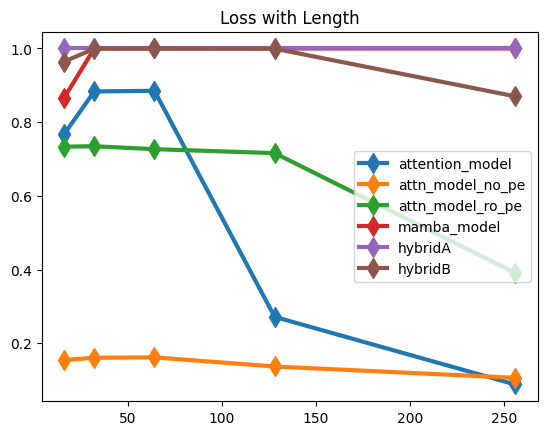

In [29]:
for model_name, model in models_dict.items():
    plt.plot([16, 32, 64, 128, 256], loss_dict[model_name], linewidth=3, marker='d', markersize=10, label=model_name)
plt.legend()
plt.title('Loss with Length')

Text(0.5, 1.0, 'Loss with epoch num')

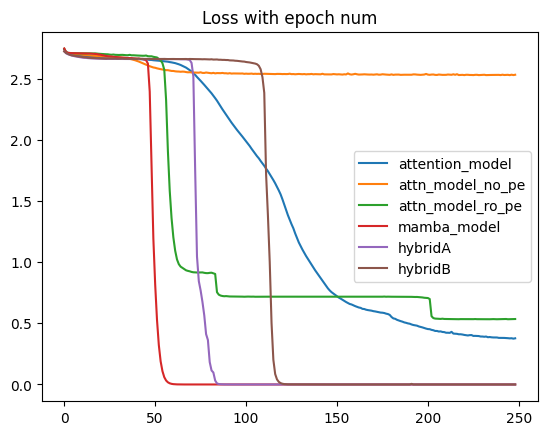

In [30]:
for model_name, model in models_dict.items():
    state = torch.load('model_savings/' + model_name + '/state.pt', map_location=torch.device('cpu'))
    plt.plot(state['test_loss'], label = model_name)
plt.legend()
plt.title('Loss with epoch num')